In [1]:
import chainer


In [2]:
chainer.print_runtime_info()

Platform: Windows-10-10.0.17763-SP0
Chainer: 6.3.0
NumPy: 1.16.4
CuPy: Not Available
iDeep: Not Available


# irisのデータ

In [30]:
# データの読み込み
from sklearn.datasets import load_iris
x,t = load_iris(return_X_y=True)
print('x:',x.shape,x[0])#アヤメの萼片の幅・長さ、花びらの幅・長さ
print('t:',t.shape,t[0])#アヤメの種類のラベル

x: (150, 4) [5.1 3.5 1.4 0.2]
t: (150,) 0


In [31]:
# データの形式をChainerに合わせる
print("x_type:{},t_type:{}".format(type(x),type(t)))
print("x_type:{},t_type:{}".format(type(x[0][0]),type(t[0])))

x = x.astype('float32')
t = t.astype('int32')
print("x_type:{},t_type:{}".format(type(x[0][0]),type(t[0])))


x_type:<class 'numpy.ndarray'>,t_type:<class 'numpy.ndarray'>
x_type:<class 'numpy.float64'>,t_type:<class 'numpy.int32'>
x_type:<class 'numpy.float32'>,t_type:<class 'numpy.int32'>


In [44]:
#データセットの分割
#テストデータ(*_test)、検証用データ(*_val)、訓練データ(*_train)に分割
#テストデータは全体の3割、検証用データ訓練データは残りの6割。
#検証用データは残りの6割のうちからさらに3割＝全体の2割くらいかな。訓練データは全体の5割
from sklearn.model_selection import train_test_split
x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)
print("全体のサイズ:",x.shape)
print("テストデータのサイズ：",x_test.shape)
print("訓練検証用データ:",x_train_val.shape)
print("訓練用データのサイズ:",x_train.shape," 検証用データのサイズ:",x_val.shape)


全体のサイズ: (150, 4)
テストデータのサイズ： (45, 4)
訓練検証用データ: (105, 4)
訓練用データのサイズ: (73, 4)  検証用データのサイズ: (32, 4)


In [60]:
#ネットワークの作成
import chainer.links as L #全結合のレイヤー
import chainer.functions as F #ファンクション
from chainer import Sequential

# net としてインスタンス化
n_input = 4#入力次元数
n_hidden = 10#２つめの全結合層への入力次元数
n_output = 3#出力次元数

net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

In [61]:
#最適化手法（訓練時の手法）をSGDに決定。インスタンス化する。
optimizer = chainer.optimizers.SGD(lr=0.01)
optimizer.setup(net)

In [62]:
#ネットワークの訓練用パラメータ
n_epoch = 30
n_batchsize = 16

In [63]:
import numpy as np

In [64]:
iteration = 0

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}


for epoch in range(n_epoch):

    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(x_train)))
    # range(0, 73)
    #[18 30 43 38 28 13 25 22  7 70 26 ... ]73までの数値がランダムに配列
    #データを取り出すときのindexとして使う

    # 各バッチ毎の目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []

    for i in range(0, len(order), n_batchsize):
        #73/16 = 4.5 →５回分回る
        # バッチを準備
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index,:]
        t_train_batch = t_train[index]

        # 予測値を出力
        y_train_batch = net(x_train_batch)

        # 目的関数を適用し、分類精度を計算
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)

        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1

    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)

    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)

    # 結果の表示
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}, accuracy:{:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array, accuracy_train))

    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch: 0, iteration: 5, loss (train): 1.2687, loss (valid): 1.0720, accuracy:0.2472
epoch: 1, iteration: 10, loss (train): 1.1622, loss (valid): 1.0216, accuracy:0.2569
epoch: 2, iteration: 15, loss (train): 1.0877, loss (valid): 0.9730, accuracy:0.2889
epoch: 3, iteration: 20, loss (train): 1.0241, loss (valid): 0.9131, accuracy:0.3167
epoch: 4, iteration: 25, loss (train): 0.9464, loss (valid): 0.8599, accuracy:0.5208
epoch: 5, iteration: 30, loss (train): 0.8955, loss (valid): 0.8234, accuracy:0.5764
epoch: 6, iteration: 35, loss (train): 0.8500, loss (valid): 0.8000, accuracy:0.6056
epoch: 7, iteration: 40, loss (train): 0.8310, loss (valid): 0.7775, accuracy:0.5667
epoch: 8, iteration: 45, loss (train): 0.7998, loss (valid): 0.7538, accuracy:0.5861
epoch: 9, iteration: 50, loss (train): 0.7820, loss (valid): 0.7351, accuracy:0.7028
epoch: 10, iteration: 55, loss (train): 0.7580, loss (valid): 0.7145, accuracy:0.8653
epoch: 11, iteration: 60, loss (train): 0.7438, loss (valid): 0.6

In [65]:
order = np.random.permutation(range(len(x_train)))
print(range(len(x_train)))
print(order)
len(order)

range(0, 73)
[20 70 67  5 49  4 10 21 46 23 69 36 40  9 22 52 35 32 53 65 11 48 55 68
 71 42 58 16 56 72 54 50 64 33 51 30 28  0 41 34 59 13  7 61 44  3 27 47
  1 24 57 29 15 26  8 38 31 66 43 60 63 39 25  2 12 45  6 37 18 19 62 17
 14]


73

In [66]:

%matplotlib inline
import matplotlib.pyplot as plt

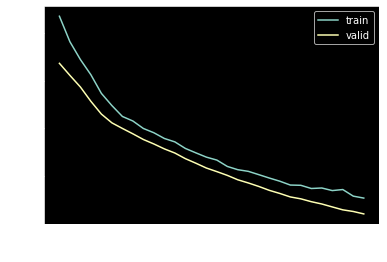

In [67]:

# 目的関数の出力 (loss)
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()  # 凡例の表示

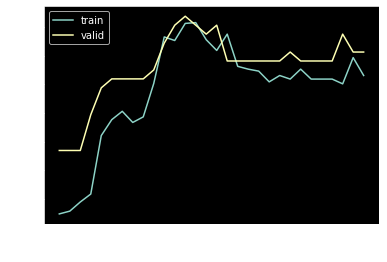

In [68]:
# 分類精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()  # 凡例の表示

In [69]:
# テストデータで予測値を計算
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)

In [71]:
accuracy_test = F.accuracy(y_test, t_test)
print(accuracy_test.array)

0.6666667


# mnistのデータで学習


In [72]:
#データの取得
train, test = chainer.datasets.get_mnist()


In [73]:
print(len(train))
print(len(train[0]))
print(len(train[0][0]))
print(train[0][1])
## train 6万個のデータ。[ [[画像のデータ784],[数字のラベル1]],[],[],....,[6万]]
## train 6万

60000
2
784
5


In [77]:
# データの分割
x_train_val, t_train_val = train._datasets
x_test, t_test = test._datasets
x_train = x_train_val
t_train = t_train_val
print("x_train_valのshape：",x_train_val.shape)
print("t_train_valのlength：",len(t_train_val))
print("t_train_valの値：",t_train_val[0])
#x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)
#print("分割後:",len(x_train),len(x_val))

x_train_valのshape： (60000, 784)
x_train_valの中身の長さ： 784
t_train_valのlength： 60000
t_train_valの値： 5


In [0]:
#データの形式確認
print("x_type:{},t_type:{}".format(type(x_train_val[0][0]),type(t_train_val[0])))

# データの形式をChainerに合わせる
#x = x.astype('float32')
#t = t.astype('int32')

In [90]:

# ネットワークの作成
from chainer import Sequential

# net としてインスタンス化
n_input = 784
n_hidden = 50
n_output = 10

net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)


In [91]:
optimizer = chainer.optimizers.SGD(lr=0.1)
optimizer.setup(net)

In [92]:
#ネットワークの訓練用パラメータ
n_batchsize = 100
iters_sum = 10000
n_epoch = 16
print(n_epoch)

16


In [93]:
np.random.permutation(range(len(x_train))).size

60000

In [94]:
iteration = 0

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}


for epoch in range(n_epoch):

    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(x_train)))
    # range(0, 60000)
    #データを取り出すときのindexとして使う

    # 各バッチ毎の目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []

    for i in range(0, len(order), n_batchsize):
        #60000/100 = 600 →600回分回る
        # バッチを準備
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index,:]
        t_train_batch = t_train[index]

        # 予測値を出力
        y_train_batch = net(x_train_batch)

        # 目的関数を適用し、分類精度を計算
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)

        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1

    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)

    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)

    # 結果の表示
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}, accuracy:{:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array, accuracy_train))

    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch: 0, iteration: 600, loss (train): 0.4737, loss (valid): 0.2498, accuracy:0.8642
epoch: 1, iteration: 1200, loss (train): 0.2198, loss (valid): 0.1804, accuracy:0.9353
epoch: 2, iteration: 1800, loss (train): 0.1672, loss (valid): 0.1379, accuracy:0.9502
epoch: 3, iteration: 2400, loss (train): 0.1377, loss (valid): 0.1159, accuracy:0.9593
epoch: 4, iteration: 3000, loss (train): 0.1156, loss (valid): 0.0973, accuracy:0.9658
epoch: 5, iteration: 3600, loss (train): 0.1011, loss (valid): 0.0886, accuracy:0.9703
epoch: 6, iteration: 4200, loss (train): 0.0902, loss (valid): 0.0738, accuracy:0.9732
epoch: 7, iteration: 4800, loss (train): 0.0817, loss (valid): 0.0671, accuracy:0.9758
epoch: 8, iteration: 5400, loss (train): 0.0742, loss (valid): 0.0598, accuracy:0.9772
epoch: 9, iteration: 6000, loss (train): 0.0671, loss (valid): 0.0519, accuracy:0.9800
epoch: 10, iteration: 6600, loss (train): 0.0606, loss (valid): 0.0519, accuracy:0.9815
epoch: 11, iteration: 7200, loss (train): 0

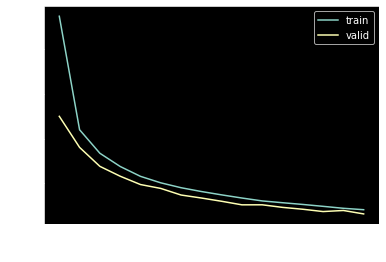

In [95]:

# 目的関数の出力 (loss)
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()  # 凡例の表示

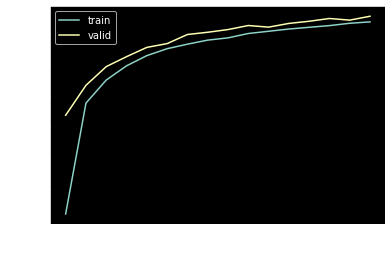

In [96]:
# 分類精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()  # 凡例の表示

* ネットワークの初期化をしたいときはどこから走らせればよいのか
 optimizerのとこ？